<a href="https://colab.research.google.com/github/rakshitgupta22/GestureSense/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## We are working on classification of Warn, Turn and Circle gestures

## Project Result Outline
- [EDA and Data Preparation (selected milestone 1 content)](#EDA)
	- [Shift the origin of the data to the center of the body](#Shifttheorigin)
	- [Evaluating polar angle, angular velocity, and angular acceleration of from (x,y)](#angle-data)
	- [Store/write the polar angle velocity and polar angle acceleration data in the 3rd and the 4th component of each dataset.](#storing-angle-data)
- [Classification with LSTM (selected milestone 2 content)](#LSTM-classification)
	- [Data preparation for LSTM by Keras](#Keras-data)
	- [Split data to train(80%) and test(20%)](#Train-test-split)
	- [LSTM model performance with different configurations](#lstm-model)
	- [LSTM model performance with different datasets](#differnt-datasets)
	- [Reasons for the varying performance due to different model configurations or datasets](#performance-reasons)


- [Analyzing an optimal classification model(milestone 3)](#optimal-model)

	- [Optimal model with GridSearchCV](#GridSearchCV)
	- [confusion matrix and classification report for analyzing the binary classification result](#confusion-matrix-and-classification-report)

	- [Best ML algorithm and baseline accuracy discssion](#baseline-accuracy)
	- [CNN-LSTM model](#CNN-LSTM-model)
	- [Summary of what factor combination yields best prediction result](#factor-summary)
	- [Refine/repeat/discussion of the results](#result-discssion)
  
  
- [Bonus item B1](#bonus-B1)
	- [4 gestures recognition](#4-gestures)
	- [9 gestures recognition](#9-gestures)
- [Bonus item B2](#bonus-B2)
	- [Better results with other ML model](#Other-model)
	- [Better results with other data model](#Other-data)
- [Additional related results not shown above](#additional_results)

**Load packages:**

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 You may use [this chrome app](https://script.google.com/macros/s/AKfycbxbGNGajrxv-HbX2sVY2OTu7yj9VvxlOMOeQblZFuq7rYm7uyo/exec) to copy the CS256Project folder that I shared with you to your own drive.

In [ ]:
root = "./drive/My Drive/CS256Project/data"

(os.path.exists(root)) #Checking if the data paths indeed exist and are valid.

True

- Import libraries and models needed for this work

In [ ]:
import numpy as np
import math
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv2D
from keras.utils.np_utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
import random
import pandas as pd
import colorsys
import os
from PIL import Image, ImageDraw
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import pad_sequences
from itertools import combinations

<a name="EDA"></a>
## EDA and Data Preparation (selected milestone 1 content)
---

Everyone must put the copied folder in the exact path shown below so you collaborate and get graded easily.   
**No project score will be given for not following this folder configuration**    
(Our grader is *not reponsible to figure out your own* perferred Google *folder* configuration)   
Basically, you simply need to use the chrome app above to copy the entire CS256Project folder to your Google doc root folder

In [ ]:
gestures_data_path = "./drive/My Drive/CS256Project/data/"
gestures_2d_path = os.path.join(gestures_data_path, "gestures_basic_d2")

(os.path.exists(gestures_data_path),
 os.path.exists(gestures_2d_path)
) #Checking if the data paths indeed exist and are valid.

(True, True)

In [ ]:
gestures = ['circle', 'turn']

## Exploring data

In [ ]:
# Sample Datapoint Properties
class_label = "abort"
video_id = "1_0"
n_frames = 24
# Extract a sample data and see what is in it
sample_2d_data_path = os.path.join(gestures_2d_path, class_label, f"{class_label}_{video_id}.mp4.npz")
data = np.load(sample_2d_data_path, allow_pickle=True)
# What does the data contain?
data.files

['boxes', 'segments', 'keypoints', 'metadata']

In [ ]:
data['keypoints'].shape

(24, 2)

### keypoints is where it stores the (x,y) coordindate values

In [ ]:
coords = data['keypoints']
coords[0,1].shape

(1, 4, 17)

In [ ]:
nfr = data['keypoints'].shape[0] # number of frames
coords = data['keypoints']
coords[0,1].shape

(1, 4, 17)

### There are 17 labeled joints as generated from a research algorithm based on the human body image.

**The joint is indexed as follows**.   
0  - Nose   
1  - left eye   
2  - Right eye   
3  - left ear   
4  - Right ear   
5  - left shoulder   
6  - Right shoulder   
7  - left elbow   
8  - Right elbow   
9  - left wrist   
10  - Right wrist   
11  - left hip   
12  - Right hip   
13  - left knee   
14  - Right knee   
15  - left Ankle   
16  - Right Ankle   


<img alt="17 labeled joints" src="https://drive.google.com/uc?export=view&id=1fsCUlc7fetOIRpyL6_emdeFPzu1zJUHn">

### (x,y) coordinate of the first frame in the given sample

In [ ]:
coords[0][1][0][:,16]
# The first two components are (x,y) coordinate values

array([2.5641040e+02, 4.1656277e+02, 0.0000000e+00, 1.2290478e-02],
      dtype=float32)

### Let's take a tranponse so we can access the (x,y) coordindate easier

In [ ]:
# [0][1][0] because... [frame_id][always 1][0 to remove extra dimension]
# transpose(1, 0) to make it shape (17, 4) so first index is keypoint index
coords_0 = coords[0][1][0].transpose(1, 0)
coords_0.shape, coords_0

((17, 4),
 array([[2.9177484e+02, 1.8652383e+02, 0.0000000e+00, 1.1042018e+00],
        [3.0136520e+02, 1.7873605e+02, 0.0000000e+00, 1.5192554e+00],
        [2.8278391e+02, 1.7873605e+02, 0.0000000e+00, 1.7079070e+00],
        [3.1694955e+02, 1.8592477e+02, 0.0000000e+00, 1.2796223e+00],
        [2.7139536e+02, 1.8472665e+02, 0.0000000e+00, 1.4278147e+00],
        [3.4332303e+02, 2.4822697e+02, 0.0000000e+00, 2.5107551e-01],
        [2.4322366e+02, 2.4523167e+02, 0.0000000e+00, 2.3285715e-01],
        [3.4931699e+02, 3.2550568e+02, 0.0000000e+00, 4.2901537e-01],
        [2.3183511e+02, 3.2670383e+02, 0.0000000e+00, 4.9821147e-01],
        [3.5710916e+02, 4.0937405e+02, 0.0000000e+00, 4.2143461e-01],
        [2.2763934e+02, 4.0398254e+02, 0.0000000e+00, 3.7857029e-01],
        [3.2414230e+02, 4.0278439e+02, 0.0000000e+00, 7.1696095e-02],
        [2.6000681e+02, 3.9919003e+02, 0.0000000e+00, 1.0201875e-01],
        [3.2414230e+02, 4.7467157e+02, 0.0000000e+00, 1.6252953e-01],
        [2

In [ ]:
coords_ = []
for i in range(nfr):
  coords_.append(coords[i][1][0].transpose(1, 0))

coords_ = np.array(coords_)
coords_.shape

(24, 17, 4)

<a name="Shifttheorigin"></a>
## Shift the origin to the nose and recalculate the new (x,y) coordinate for all datasets and
# overwrite the original (x,y) values

In [ ]:
new_origin_joint_num = 0 # Nose

for i in range(nfr):
  nose_x, nose_y = coords_[i][new_origin_joint_num][:2] # Get the (x,y) coordinates of the new origin
  coords_[i,:,0] -= nose_x # Shift x-coordinates
  coords_[i,:,1] -= nose_y # Shift y-coordinates

In [ ]:
for i in range(len(coords_)):
  coords[i][1][0] = coords_[i].transpose(1, 0)

## Helper Function : 3D to 2D

In [ ]:
def transpose_result(coords):
  transposed_coords = []
  for i in range(len(coords)):
    transposed_coords.append(coords[i][1][0].transpose(1, 0).copy())
  return transposed_coords

<a name="angle-data"></a>
# Calculate the polar angle velocity and the polar angle acceleration based on the transformed (x,y) from above

In [ ]:
def cal_vel_acc(gesture_name, sample_number):
  gestures_data_path = "./drive/My Drive/CS256Project/data/"
  gestures_2d_path = os.path.join(gestures_data_path, "gestures_basic_d2")

  if not (os.path.exists(gestures_data_path) and os.path.exists(gestures_2d_path)):
    print("Error: Can not access google drive folder")
    return -1

  sample_2d_data_path = os.path.join(gestures_2d_path, gesture_name, f"{gesture_name}_{sample_number}.mp4.npz")
  data = np.load(sample_2d_data_path, allow_pickle=True)

  joint_lables = {
    0: "nose",
    1: "left eye",
    2: "Right eye",
    3: "left ear",
    4: "Right ear",
    5: "left shoulder",
    6: "right shoulder",
    7: "left elbow",
    8: "Right elbow",
    9: "left wrist",
    10: "Right wrist",
    11: "left hip",
    12: "Right hip",
    13: "left knee",
    14: "Right knee",
    15: "left ankle",
    16: "Right ankle"
  }

  nfr = data['keypoints'].shape[0] # number of frames
  coords = data['keypoints']

  coords_ = []
  for i in range(nfr):
    coords_.append(coords[i][1][0].transpose(1, 0))

  coords_ = np.array(coords_)

  new_origin_joint_num = 0 # Nose

  for i in range(nfr):
    nose_x, nose_y = coords_[i][new_origin_joint_num][:2]
    coords_[i,:,0] -= nose_x
    coords_[i,:,1] -= nose_y

  for i in range(len(coords_)):
    coords[i][1][0] = coords_[i].transpose(1, 0)

  pa = []
  for i in range(len(coords_)):
    pai = []
    for j in range(len(coords_[i])):
      pai.append(np.arctan2(coords_[i][j][1], coords_[i][j][0]))
    pa.append(pai)

  pa = np.array(pa)

  vel_pa = np.diff(pa, axis = 0)

  pv = []
  coords[0][1][0][2] = 0
  pv.append(coords[0][1][0][2])
  for i in range(1, len(coords)):
    coords[i][1][0][2] = vel_pa[i-1]
    pv.append(vel_pa[i-1])

  pv = np.array(pv)
  acc = np.diff(pv, axis = 0)

  coords[0][1][0][3] = 0
  for i in range(1, len(coords)):
    coords[i][1][0][3] = acc[i-1]

  coords_ = []
  for i in range(nfr):
    coords_.append(coords[i][1][0].transpose(1, 0))

  coords_ = np.array(coords_)

  return tuple([coords, coords_, nfr, joint_lables])


<a name="storing-angle-data"></a>
## Store the velocity and acceleration in the 3rd and 4th component of the dataset

In [ ]:
file_names = []

for gesture in gestures:
    folder_path = "/content/drive/MyDrive/CS256Project/data/gestures_visualized/" + gesture
    # print(folder_path)
    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            file_names.append(file)

datapath = "/content/drive/MyDrive/CS256Project/deduced_data"
if not os.path.exists(datapath): # checking if already exist
    os.makedirs(datapath) # creating dir

for file in file_names:
    gesture = file.split('_',1)[0]
    video_idx = file.split('_',1)[1].split('.')[0]
    # print(gesture, video_idx)
    _, coordst, n_frames, joint_lables = cal_vel_acc(gesture, video_idx)
    datapath = f"/content/drive/MyDrive/CS256Project/deduced_data/{gesture}"
    if not os.path.exists(datapath): # checking if already exist
        os.makedirs(datapath) # creating dir
    np.savez(f"/content/drive/MyDrive/CS256Project/deduced_data/{gesture}/{file.split('.')[0]}", arr = coordst)

<a name="LSTM-classification"></a>
# Classification with LSTM (selected milestone 2 content)

<a name="Keras-data"></a>
## Data preparation for LSTM by Keras

In [ ]:
# this functions creates folders to store test & train data

def create_folders(subdirectories):
    for subdirectory in subdirectories: # looping through folders
        path = os.path.join(root, subdirectory)
        if not os.path.exists(path): # checking if already exist
            os.makedirs(path) # creating dir

In [ ]:
subdirectories = ['test', 'train', 'test/angle', 'test/velocity', 'test/acceleration', 'train/angle', 'train/velocity', 'train/acceleration'] + gestures
create_folders(subdirectories)

<a name="Train-test-split"></a>
## Split data to train(80%) and test(20%)

In [ ]:
# Define a file name structure
train_file_x_name = '/train/{}/{}_gestures_x_train.txt'
train_file_y_name = '/train/gestures_y_{}_train.txt'
test_file_x_name = '/test/{}/{}_gestures_x_test.txt'
test_file_y_name = '/test/gestures_y_{}_test.txt'

In [ ]:
gestures_2d_path = os.path.join(gestures_data_path, "gestures_basic_d2")
MAX_FRAMES_PER_VIDEO = 72

In [ ]:
# Get filenames for specific gesture
def list_filenames_for_gesture(gesture):
  # Define the path to the directory containing gesture files
  file_path = f"{gestures_2d_path}/{gesture}"
  # Get a list of filenames for gesture files in the directory
  filenames = [fname for fname in os.listdir(file_path) if fname.endswith('.mp4.npz')]
  return filenames
print(list_filenames_for_gesture)

<function list_filenames_for_gesture at 0x7ff2583c3250>


In [ ]:
#Then choose the relevant joints as features for the X_train
relevant_joints = [5,6,7,8,9,10]
joint_names = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'Right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']

In [ ]:
# Get filenames for specific gesture
def list_filenames_for_gesture(gesture):
  # Define the path to the directory containing gesture files
  file_path = f"{gestures_2d_path}/{gesture}"
  # Get a list of filenames for gesture files in the directory
  filenames = [fname for fname in os.listdir(file_path) if fname.endswith('.mp4.npz')]
  return filenames
print(list_filenames_for_gesture)

<function list_filenames_for_gesture at 0x7ff2583c32e0>


In [ ]:
def shift_coord(coords):
    shifted_coords = []
    for frame in coords:
        current_frm_crds = frame[1][0].transpose(1, 0).copy() # get data in 2D form
        nose_coordinate = current_frm_crds[0][:2].copy() # coordinates for nose joint
        shifted_frame = []
        for coord in current_frm_crds:
            shifted_coord = [coord[0] - nose_coordinate[0], coord[1] - nose_coordinate[1], coord[2], coord[3]] # shifting coordinates
            shifted_frame.append(shifted_coord) # storing in another variable
        for i, coord in enumerate(shifted_frame):
            angle = math.atan2(coord[1], coord[0]) # calculating polar angle
            if i == 0:
                vel = 0 # initial polar velocity is zero
            else:
                vel = coord[2] - shifted_frame[i-1][2] # calculating velocity
            coord[2], coord[3] = angle, vel
        shifted_coords.append(shifted_frame) # storing updated data2
    return shifted_coords

In [ ]:
def shifted_coords_gesture(gesture, file_name):
    sample_2d_data_path = os.path.join(gestures_2d_path, gesture, file_name) # getting file path
    data = np.load(sample_2d_data_path, allow_pickle=True)['keypoints'] # loading data for some gesture
    return shift_coord(data)

In [ ]:
# This function shuffles the training and testing data for the given feature and writes the shuffled data to X and Y files
def shuffle(feature, joints_train_data, joints_test_data, max_frames_in_any_video):
    print(max_frames_in_any_video)
    # Generate a random permutation of indexes for training and testing data
    training_shuffled_indexes = np.random.permutation(len(joints_train_data[0]))
    test_shuffled_indexes = np.random.permutation(len(joints_test_data[0]))

    # Write shuffled training and testing data to X files
    for joints_data, file_template in zip([joints_train_data, joints_test_data], [train_file_x_name, test_file_x_name]):
        # Select the shuffled indexes based on whether the data is training or testing data
        shuffled_indexes = training_shuffled_indexes if joints_data is joints_train_data else test_shuffled_indexes
        # For each relevant joint, write the shuffled data to the corresponding X file
        for rj_idx, joint_index in enumerate(relevant_joints):
            joint_videos = joints_data[rj_idx]
            #Pad data
            joint_data_str = '\n'.join([' '.join([str(x) for x in video_data] + ['0.0000000'] * (max_frames_in_any_video - len(video_data)))
            for video_data in [joint_videos[i] for i in shuffled_indexes]])
            file_x = file_template.format(feature, joint_names[joint_index])
            # If the file already exists, remove it
            if os.path.exists(root + file_x):
                os.remove(root + file_x)
            # Write the shuffled data to the X file
            with open(root + file_x, 'a') as writeFile:
                writeFile.write(joint_data_str)

    # Write shuffled training and testing data to Y files
    for joint_data, file_template in zip([joints_train_data, joints_test_data], [train_file_y_name, test_file_y_name]):
        # Select the shuffled indexes based on whether the data is training or testing data
        shuffled_indexes = training_shuffled_indexes if joint_data is joints_train_data else test_shuffled_indexes
        # Get the target data for the joint
        target_data = joint_data[-1]
        file_y = file_template.format(feature)
        # If the file already exists, remove it
        if os.path.exists(root + file_y):
            os.remove(root + file_y)
        # Write the shuffled target data to the Y file
        with open(root + file_y, 'a') as writeFile:
            writeFile.write('\n'.join([target_data[i] for i in shuffled_indexes]))


In [ ]:
def generate_data(feature='velocity'):
    # If the input feature is 'both', generate velocity data and then set the feature to 'angle'
    if feature == 'both':
        generate_data('velocity')
        feature = 'angle'
    # check if the input feature is in 'angle', 'velocity', or 'acceleration'
    if feature not in ['angle', 'velocity', 'acceleration']:
        raise ValueError('Wrong data argument', feature)

    # Create empty lists to store training and testing data for relevant joints.
    joints_train_data = [[] for _ in range(len(relevant_joints) + 1)]
    joints_test_data = [[] for _ in range(len(relevant_joints) + 1)]
    max_frames_in_any_video = 0

    # Loop through each gesture in the list of gestures
    for gesture_idx, gesture in enumerate(gestures):
        # Get a list of file names for the current gesture
        gesture_file_names = list_filenames_for_gesture(gesture)
        # Select a random set of indices for test files
        test_file_indices = set(random.sample(range(len(gesture_file_names)), math.floor(len(gesture_file_names) * 0.2)))

        # Loop through each file name in the list of file names for the current gesture
        for file_idx, file_name in enumerate(gesture_file_names):
            # Get the shuffled coordinates for the current file name
            shuffled_coords = np.array(shifted_coords_gesture(gesture, file_name))
            no_of_frames = len(shuffled_coords)  # Get the number of frames in the shuffled coordinates

            # If the number of frames in the shuffled coordinates is greater than the current maximum number of frames in any video, set it as the new maximum
            if no_of_frames > max_frames_in_any_video:
                max_frames_in_any_video = no_of_frames

            # Determine whether to store the current data in the training or testing data list
            joints_data = joints_test_data if file_idx in test_file_indices else joints_train_data

            # Loop through each relevant joint index and append the Z-coordinates of the shuffled coordinates to the relevant joint data list
            for rj_idx, joint_index in enumerate(relevant_joints):
                joints_data[rj_idx].append(list(shuffled_coords[:, joint_index, 2]))

            joints_data[-1].append(str(gesture_idx + 1)) # Append the gesture index plus one to the last element of the current joint data list
        print(gesture, max_frames_in_any_video)
        print("----------------------")
    # shuffle the training and testing data for given feature and the maximum number of frames in any video
    shuffle(feature, joints_train_data, joints_test_data, 144)

In [ ]:
generate_data('both') # DO NOT RUN AGAIN

circle 72
----------------------
turn 72
----------------------
144
circle 72
----------------------
turn 72
----------------------
144


In [ ]:
def re_shift_coord_acc(coords):
    shifted_coords = shift_coord(coords) # getting original shifted coordinate data
    for frame in shifted_coords:
        for coord in frame:
            coord[2] = coord[3] # putting velocity in 3rd column

        for i, coord in enumerate(frame):
            if i == 0:
                acc = 0 # initial acceleration is zero
            else:
                acc = coord[2] - frame[i-1][2] # calculating acceleration as change in velocity
            coord[3] = acc

    return shifted_coords # returning updated data

In [ ]:
def shifted_coords_gesture(gesture, file_name): # redefining shifted_coords_gesture function to work with acceleration
    sample_2d_data_path = os.path.join(gestures_2d_path, gesture, file_name) # getting file path
    data = np.load(sample_2d_data_path, allow_pickle=True)['keypoints'] # loading data for some gesture
    return re_shift_coord_acc(data)

In [ ]:
generate_data('acceleration')

circle 72
----------------------
turn 72
----------------------
144


#Loading Data

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

In [ ]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

In [ ]:
# Add files to the path
def add_filenames(filenames, data, group):
  for joint_index in relevant_joints:
	  filenames += ['/{}/{}_gestures_x_{}.txt'.format(data, joint_names[joint_index], group)]

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(data, group, prefix=''):
	filepath = prefix + '/' + group
	filenames = list()
	if data == 'both':
		add_filenames(filenames, 'angle', group)
		add_filenames(filenames, 'velocity', group)
	else:
		add_filenames(filenames, data, group)

	print('filenames:', filenames)
	# print('filenames shape:', filenames.shape)

	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + '/' + group + '/gestures_y_' + data + '_' +group+'.txt')
	return X, y

In [ ]:
# load the dataset, returns train and test X and y elements
def load_dataset(data, prefix=''):
	# load all train
	trainX, trainy = load_dataset_group(data, 'train', prefix)
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group(data, 'test', prefix)
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print('[samples, time steps, features]',trainX.shape, trainy.shape, '[samples, time steps, features]',testX.shape, testy.shape)
	return trainX, trainy, testX, testy

<a name="lstm-model"></a>
## LSTM model performance with different configurations

In [ ]:
trainX, trainy, testX, testy = load_dataset('acceleration', '/content/drive/MyDrive/CS256Project/data')

filenames: ['/acceleration/left_shoulder_gestures_x_train.txt', '/acceleration/Right_shoulder_gestures_x_train.txt', '/acceleration/left_elbow_gestures_x_train.txt', '/acceleration/right_elbow_gestures_x_train.txt', '/acceleration/left_wrist_gestures_x_train.txt', '/acceleration/right_wrist_gestures_x_train.txt']
(99, 144, 6) (99, 1)
filenames: ['/acceleration/left_shoulder_gestures_x_test.txt', '/acceleration/Right_shoulder_gestures_x_test.txt', '/acceleration/left_elbow_gestures_x_test.txt', '/acceleration/right_elbow_gestures_x_test.txt', '/acceleration/left_wrist_gestures_x_test.txt', '/acceleration/right_wrist_gestures_x_test.txt']
(24, 144, 6) (24, 1)
[samples, time steps, features] (99, 144, 6) (99, 2) [samples, time steps, features] (24, 144, 6) (24, 2)


In [ ]:
import itertools
# params_grid = {'num_lstm_layers':[1,2,3],
#                'lstm_neurons':[128, 150, 200],
#                'dropout_rate':[0.3, 0.4, 0.5],
#                'num_dense_layers':[1,2,3,4],
#                'dense_neurons':[64, 128],
#                'batch_size':[32, 64]}

params_grid = {'num_lstm_layers':[3],
               'lstm_neurons':[150],
               'dropout_rate':[0.5],
               'num_dense_layers':[2],
               'dense_neurons':[128],
               'batch_size':[64]}


param_keys = params_grid.keys()
param_values = params_grid.values()

# Generate all possible permutations
param_permutations = list(itertools.product(*param_values))

# Create a list of dictionaries for each permutation
param_configs = [dict(zip(param_keys, param_perm)) for param_perm in param_permutations]

In [ ]:
# This function takes in the following arguments:
# trainX: training input data
# trainy: training output/target data
# testX: testing input data
# testy: testing output/target data
# num_lstm_layers: number of LSTM layers
# lstm_neurons: number of LSTM neurons
# dropout_rate: rate of dropout for regularization
# num_dense_layers: number of dense layers
# dense_neurons: number of neurons in each dense layer
# batch_size: size of mini-batch for training

def evaluate_model(trainX, trainy, testX, testy, num_lstm_layers, lstm_neurons, dropout_rate, num_dense_layers, dense_neurons, batch_size):
	verbose, epochs = 0, 15 # Set verbose and number of epochs
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1] # Get the number of timesteps, features, and outputs
	model = Sequential() # Create a Sequential model
	for i in range(1, num_lstm_layers): # Add specified number of LSTM layers with specified number of neurons and input shape
		model.add(LSTM(lstm_neurons, input_shape=(n_timesteps,n_features),return_sequences=True))
	model.add(LSTM(lstm_neurons, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(dropout_rate)) # Add a dropout layer with specified rate
	for i in range(num_dense_layers): # Add the specified number of dense layers with specified number of neurons and ReLU activation
		model.add(Dense(dense_neurons, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax')) # Add a dense output layer with softmax activation
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metric

	model.summary() # Print model summary
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose) # Fit the model to the training data
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0) # Evaluate the model on the testing data and get the accuracy

	# return accuracy # Return the accuracy
	return accuracy


In [ ]:
# summarize scores
def summarize_results(scores, params, data_point):
	# print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
	print(f'Max Accuracy of {max(scores)} obtained with {params[scores.index(max(scores))]}')
	scores_df = pd.DataFrame.from_dict(params)
	scores_df['Accuracy'] = scores
	scores_df.to_csv(f"{root}/model_architectures_{data_point}.csv", sep=",", index=False)

In [ ]:
# to run an experiment
def run_experiment(data_point):
	# load data
	global trainX, trainy, testX, testy
	# repeat experiment
	scores = list()
	for params in param_configs: # looping through each configuration
		score = evaluate_model(trainX, trainy, testX, testy, params['num_lstm_layers'], params['lstm_neurons'], params['dropout_rate'],
                         params['num_dense_layers'], params['dense_neurons'], params['batch_size'])	  # evaluating model performance for specific parameters
		score = score * 100.0 # getting score as a percentage
		print(f'>Score with {params}: {format(score, ".3f")}')  # printing accuracy score
		scores.append(score)
	# summarize results
	summarize_results(scores, param_configs, data_point)

In [ ]:
%%time
# run the experiment
run_experiment("acceleration")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 144, 150)          94200     
                                                                 
 lstm_4 (LSTM)               (None, 144, 150)          180600    
                                                                 
 lstm_5 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               19328     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 2)                

<a name="differnt-datasets"></a>
## LSTM model performance with different datasets

In [ ]:
trainXl, trainyl, testXl, testyl = {}, {}, {}, {} # dictionaries to store train & test data
for data_points in ['angle', 'velocity', 'acceleration']: # retriving train & test data for each data point
  trainXl[data_points], trainyl[data_points], testXl[data_points], testyl[data_points] = load_dataset(data_points, '/content/drive/MyDrive/CS256Project/data/data_for_lstm')

filenames: ['/angle/left_shoulder_gestures_x_train.txt', '/angle/Right_shoulder_gestures_x_train.txt', '/angle/left_elbow_gestures_x_train.txt', '/angle/right_elbow_gestures_x_train.txt', '/angle/left_wrist_gestures_x_train.txt', '/angle/right_wrist_gestures_x_train.txt']
(99, 72, 6) (99, 1)
filenames: ['/angle/left_shoulder_gestures_x_test.txt', '/angle/Right_shoulder_gestures_x_test.txt', '/angle/left_elbow_gestures_x_test.txt', '/angle/right_elbow_gestures_x_test.txt', '/angle/left_wrist_gestures_x_test.txt', '/angle/right_wrist_gestures_x_test.txt']
(24, 72, 6) (24, 1)
[samples, time steps, features] (99, 72, 6) (99, 2) [samples, time steps, features] (24, 72, 6) (24, 2)
filenames: ['/velocity/left_shoulder_gestures_x_train.txt', '/velocity/Right_shoulder_gestures_x_train.txt', '/velocity/left_elbow_gestures_x_train.txt', '/velocity/right_elbow_gestures_x_train.txt', '/velocity/left_wrist_gestures_x_train.txt', '/velocity/right_wrist_gestures_x_train.txt']
(99, 72, 6) (99, 1)
filen

In [ ]:
# This function takes in the following arguments:
# trainX: training input data
# trainy: training output/target data
# testX: testing input data
# testy: testing output/target data
# lstm_neurons: number of LSTM neurons
# dropout_rate: rate of dropout for regularization
# num_dense_layers: number of dense layers
# dense_neurons: number of neurons in each dense layer
# batch_size: size of mini-batch for training

def evaluate_model_compare(trainX, trainy, testX, testy, lstm_neurons, dropout_rate, num_dense_layers, dense_neurons, batch_size):
    verbose, epochs = 0, 15 # Set verbose and number of epochs
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1] # Get the number of timesteps, features, and outputs
    model = Sequential() # Create a Sequential model
    model.add(LSTM(lstm_neurons, input_shape=(n_timesteps,n_features)))  # Add an LSTM layer with specified number of neurons and input shape

    for i in range(num_dense_layers):
        model.add(Dense(dense_neurons, activation='relu'))  # Add the specified number of dense layers with specified number of neurons and ReLU activation

    model.add(Dense(n_outputs, activation='softmax')) # Add a dense output layer with softmax activation
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metric

    # Fit the model to the training data
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # Evaluate the model on the testing data and get the accuracy
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

    return accuracy # Return the accuracy


In [ ]:
import itertools
# params_grid = {'lstm_neurons':[128, 150],
#                'dropout_rate':[0.4, 0.5],
#                'num_dense_layers':[1, 2],
#                'dense_neurons':[64, 128],
#                'batch_size':[32, 64]}

params_grid = {'lstm_neurons':[128],
               'dropout_rate':[0.5],
               'num_dense_layers':[1],
               'dense_neurons':[64],
               'batch_size':[64]}


param_configs = [dict(zip(params_grid.keys(), param_perm)) for param_perm in list(itertools.product(*params_grid.values()))]

In [ ]:
def run_compare_experiment(param_config):
 global trainXl, trainyl, testXl, testyl

 for params in param_config:  # looping through each configuration
  print(f'\n||Params: {params}')
  for data_point in ['angle', 'velocity', 'acceleration']: # checking for each feature
    score = evaluate_model_compare(trainXl[data_point], trainyl[data_point], testXl[data_point], testyl[data_point], params['lstm_neurons'], params['dropout_rate'],
              params['num_dense_layers'], params['dense_neurons'], params['batch_size'])  # evaluating model performance for specific parameters
    score = score * 100.0 # getting score as a percentage
    print(f'  >{data_point}: {format(score, ".3f")}')  # printing accuracy score


In [ ]:
%%time
run_compare_experiment(param_configs)

In [ ]:
%%time
## Finding best feature and parameters by manually checking for varying parameters

param_configs = [
{'lstm_neurons': 128, 'dropout_rate': 0.4, 'num_dense_layers': 1, 'dense_neurons': 64, 'batch_size': 32},
{'lstm_neurons': 128, 'dropout_rate': 0.4, 'num_dense_layers': 2, 'dense_neurons': 64, 'batch_size': 32},
{'lstm_neurons': 128, 'dropout_rate': 0.5, 'num_dense_layers': 1, 'dense_neurons': 64, 'batch_size': 32},
{'lstm_neurons': 128, 'dropout_rate': 0.5, 'num_dense_layers': 1, 'dense_neurons': 128, 'batch_size': 32},
{'lstm_neurons': 150, 'dropout_rate': 0.4, 'num_dense_layers': 1, 'dense_neurons': 64, 'batch_size': 64},
{'lstm_neurons': 150, 'dropout_rate': 0.4, 'num_dense_layers': 2, 'dense_neurons': 128, 'batch_size': 64},
{'lstm_neurons': 150, 'dropout_rate': 0.5, 'num_dense_layers': 1, 'dense_neurons': 128, 'batch_size': 64}]

run_compare_experiment(param_configs)

<a name="performance-reasons"></a>
## Reasons for the varying performance due to different model configurations or datasets

In [ ]:
#Print average scores for varying parameters on each set of data
angle_scores = [50.000, 79.167, 62.500, 66.667, 91.667, 79.167, 75.000]
velocity_scores = [83.333, 66.667,66.667, 79.167, 75.000,  62.500, 54.167]
acceleration_scores = [91.667, 87.500, 91.667,  75.000,91.667, 79.167,83.333]

print("Mean Angle Score: " + str(np.mean(angle_scores)) )
print("Mean Velocity Score: " + str(mean(velocity_scores)))
print("Mean Acceleration Score: " + str(mean(acceleration_scores)))

**Acceleration is found to be the best feature**

*   Consistently gave higher accuracy
*   Does no overfitting or underfitting
*   Models consumed relatively less CPU time

<a name="optimal-model"></a>
# Analyzing an optimal classification model(milestone 3)

In [ ]:
gestures = ['circle', 'turn', 'warn']

In [ ]:
create_folders(gestures)

<a name="concatevideos"></a>
## Creation of Concatenated videos with two gestures in a sequence
---

In [ ]:
def generate_padded_data(feature='acceleration'):
  max_frames_in_any_video = 0

  # Loop through each gesture in the list of gestures
  for gesture_idx, gesture in enumerate(gestures):
    # Get a list of file names for the current gesture
    gesture_file_names = list_filenames_for_gesture(gesture)
    coords_list = []
  # Loop through each file name in the list of file names for the current gesture
    for file_idx, file_name in enumerate(gesture_file_names):
      # Get the shuffled coordinates for the current file name
      shuffled_coords = np.array(shifted_coords_gesture(gesture, file_name))
      coords_list.append(shuffled_coords)

    #Pad the coords list
    final_coords_list = pad_sequences(coords_list, padding='post', value=0, dtype='float', maxlen = MAX_FRAMES_PER_VIDEO)
    # print(len(final_coords_list))
    # for i in range(len(final_coords_list)):
    for i in range(len(final_coords_list)):
      np.savez(f"{root}/{gesture}/{gesture_file_names[i]}", arr=final_coords_list[i])

In [ ]:
generate_padded_data() # Do Not Run Again

In [ ]:
circle_paths, turn_paths, warn_paths = [], [], []

In [ ]:
def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]

In [ ]:
#Getting the paths of all videos in each gesture folder

for gesture in gestures:
    if gesture == "warn" and os.path.exists(os.path.join(root, gesture)):
        warn_paths.extend(list_full_paths(os.path.join(root, gesture)))
    elif gesture == "circle" and os.path.exists(os.path.join(root, gesture)):
        circle_paths.extend(list_full_paths(os.path.join(root, gesture)))
    elif gesture == "turn" and os.path.exists(os.path.join(root, gesture)):
        turn_paths.extend(list_full_paths(os.path.join(root, gesture)))

In [ ]:
#Create directories for each pair of concatenated gestures
os.makedirs("/content/drive/MyDrive/CS256Project/Milestone3/combined_data_base")
for g1 in gestures:
    for g2 in gestures:
        if g1==g2:
            continue
        else:
            path = os.path.join("/content/drive/MyDrive/CS256Project/Milestone3/combined_data_base", f"{g1}_{g2}")
            if not os.path.exists(path): # checking if already exist
                os.makedirs(path) # creating dir

In [ ]:
# DO NOT RUN AGAIN
# AS IT SAVES ALL THE CONCATENATED .NPZ ARRAYS IN DRIVE
#Concatenate and save all npz files in their respective subdirectories
i = 1
for path1 in circle_paths:
    video1 = np.load(path1, allow_pickle=True)['arr']
    j,k = 1,1
    for path2 in turn_paths:
        video2 = np.load(path2, allow_pickle=True)['arr']
        np.savez(f"/content/drive/MyDrive/CS256Project/Milestone3/combined_data_base/circle_turn/circle_turn_{i}_{j}", arr = np.array([video1, video2]))
        np.savez(f"/content/drive/MyDrive/CS256Project/Milestone3/combined_data_base/turn_circle/turn_circle_{i}_{j}", arr = np.array([video2, video1]))
        j+=1

    for path3 in warn_paths:
        video3 = np.load(path3, allow_pickle=True)['arr']
        np.savez(f"/content/drive/MyDrive/CS256Project/Milestone3/combined_data_base/circle_warn/circle_warn_{i}_{k}", arr = np.array([video1, video3]))
        np.savez(f"/content/drive/MyDrive/CS256Project/Milestone3/combined_data_base/warn_circle/warn_circle_{i}_{k}", arr = np.array([video3, video1]))
        k+=1
    i+=1


i = 1
for path1 in turn_paths:
    video1 = np.load(path1, allow_pickle=True)['arr']
    j = 1
    for path2 in warn_paths:
        video2 = np.load(path2, allow_pickle=True)['arr']
        np.savez(f"/content/drive/MyDrive/CS256Project/Milestone3/combined_data_base/turn_warn/turn_warn{i}_{j}", arr = np.array([video1, video2]))
        np.savez(f"/content/drive/MyDrive/CS256Project/Milestone3/combined_data_base/warn_turn/warn_turn{i}_{j}", arr = np.array([video2, video1]))
        j+=1
    i+=1


In [ ]:
print(len(os.listdir("/content/drive/MyDrive/CS256Project/Milestone3/combined_data_base/circle_turn/"))>0)

True


In [ ]:
combined_labels = []
target_labels = []
for g1 in gestures:
    for g2 in gestures:
        if g1 != g2:
            combined_labels.append(f"{g1}_{g2}")
            target_labels.append([gestures.index(g1), gestures.index(g2)])

In [ ]:
combined_labels

['circle_turn',
 'circle_warn',
 'turn_circle',
 'turn_warn',
 'warn_circle',
 'warn_turn']

#### Prepare X_train, X_test, y_train and y_test for concatenated videos

In [ ]:
## Fetch only the required joints from the keypoints in the data
def get_data(class_label):
  data = []
  data_path = os.path.join("/content/drive/MyDrive/CS256Project/Milestone3/combined_data_base", class_label)
  for filename in os.listdir(data_path):
    # get path of each file
    file_path = os.path.join(data_path, filename)
    # print(file_path)
    # load the numpy array from the input file
    l = np.load(file_path, allow_pickle=True)
    sample = []
    for i, frame in enumerate(l['arr']):
      #extract only the relevant joints (shoulders, elbows and wrists - both left and right)
      sample.append(frame)
    data.append(np.array(sample))
  return np.array(data)

In [ ]:
X = []
Y = []
combined_data_path = "/content/drive/MyDrive/CS256Project/Milestone3/combined_data_base/"
for idx in range(len(combined_labels)):
    X.extend(get_data(combined_labels[idx]))
    Y.extend([target_labels[idx]] * len(os.listdir(os.path.join(combined_data_path, combined_labels[idx]))))

In [ ]:
#Function used to extract polar angles, polar velocity and polar acceleration separately.
def extract_data(data, index):
  res = []
  for sample in data:
    new_sample = []
    for video in sample:
        new_video=[]
        for frame in video:
            polar_angles = []
            for joint in frame[5:11]:
                polar_angles.append(joint[index])
            new_video.append(polar_angles)
        new_sample.append(new_video)
    res.append(new_sample)
  return np.array(res)


In [ ]:
# Calling extract_data() to fetch only polar acceleration for testing with LSTM.
X_acceleration = extract_data(np.array(X), 3)
# X_test = extract_data(X_test_all, 2)

In [ ]:
print(X_acceleration.shape)
print(np.array(Y).shape)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_acceleration, np.array(Y), test_size = 0.2, random_state=30)

In [ ]:
testpath = '/content/drive/MyDrive/CS256Project/Milestone3/Combined_video_train_test'

In [ ]:
if not os.path.exists(testpath): # checking if already exist
    os.makedirs(testpath)
np.savez(f'{testpath}/X_train.npz', arr=X_train)
np.savez(f'{testpath}/X_test.npz', arr=X_test)
np.savez(f'{testpath}/y_train.npz', arr=y_train)
np.savez(f'{testpath}/y_test.npz', arr=y_test)

<a name="GridSearchCV"></a>
## Model Evaluation
---

#### Approach 1 : Use the model trained on single single gesture and predict a sequence using custom prediction function

In [ ]:
## Fetch only the required joints from the keypoints in the data
def get_data(class_label):
  data = []
  data_path = os.path.join("/content/drive/MyDrive/CS256Project/data", class_label)
  for filename in os.listdir(data_path):
    #get path of each file
    file_path = os.path.join(data_path, filename)
    # print(file_path)
    #load the numpy array from the input file
    l = np.load(file_path, allow_pickle=True)
    sample = []
    for i, frame in enumerate(l['arr']):
      #extract only the relevant joints (shoulders, elbows and wrists - both left and right)
      sample.append(frame[5:11])
    data.append(np.array(sample))
  return np.array(data)

In [ ]:
circle_samples = get_data('circle')
turn_sample = get_data('turn')
warn_sample = get_data('warn')

In [ ]:
#combining all gestures and padding the data
X_values = np.vstack((circle_samples, turn_sample, warn_sample))
#target value has 2 variables, isHello and isAbort. Target values for hello sample = [1,0] and target values for abort sample = [0,1]
target_values = np.array([[1, 0, 0]] * len(circle_samples)
                + [[0, 1, 0]] * len(turn_sample)
                + [[0, 0, 1]] * len(warn_sample))

In [ ]:
print(X_values.shape)
print(target_values.shape)

In [ ]:
#Function used to extract polar angles, polar velocity and polar acceleration separately.
def extract_data(data, index):
  res = []
  for sample in data:
    new_sample = []
    for frame in sample:
      polar_angles = []
      for joint in frame:
        polar_angles.append(joint[index])
      new_sample.append(polar_angles)
    res.append(new_sample)
  return np.array(res)

In [ ]:
# Calling extract_data() to fetch only polar acceleration for testing with LSTM.
X_acceleration = extract_data(X_values, 3)

In [ ]:
from sklearn.model_selection import train_test_split

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_acceleration, target_values, test_size=0.2, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

##### Model Training

In [ ]:
# This function takes in the following arguments:
# trainX: training input data
# trainy: training output/target data
# testX: testing input data
# testy: testing output/target data
# num_lstm_layers: number of LSTM layers
# lstm_neurons: number of LSTM neurons
# dropout_rate: rate of dropout for regularization
# num_dense_layers: number of dense layers
# dense_neurons: number of neurons in each dense layer
# batch_size: size of mini-batch for training

def evaluate_model(trainX, trainy, testX, testy, num_lstm_layers, lstm_neurons, dropout_rate, num_dense_layers, dense_neurons, batch_size):
	verbose, epochs = 0, 15 # Set verbose and number of epochs
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1] # Get the number of timesteps, features, and outputs
	model = Sequential() # Create a Sequential model
	for i in range(1, num_lstm_layers): # Add specified number of LSTM layers with specified number of neurons and input shape
		model.add(LSTM(lstm_neurons, input_shape=(n_timesteps,n_features),return_sequences=True))
		model.add(Dropout(dropout_rate)) # Add a dropout layer with specified rate
	model.add(LSTM(lstm_neurons, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(dropout_rate)) # Add a dropout layer with specified rate
	for i in range(num_dense_layers): # Add the specified number of dense layers with specified number of neurons and ReLU activation
		model.add(Dense(dense_neurons, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax')) # Add a dense output layer with softmax activation
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metric

	model.summary() # Print model summary
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose) # Fit the model to the training data
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0) # Evaluate the model on the testing data and get the accuracy

	# return accuracy # Return the accuracy
	return model, accuracy

In [ ]:
# summarize scores
def summarize_results(scores, params, data_point):
	# print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
	print(f'Max Accuracy of {max(scores)} obtained with {params[scores.index(max(scores))]}')
	scores_df = pd.DataFrame.from_dict(params)
	scores_df['Accuracy'] = scores
	scores_df.to_csv(f"{root}/model_architectures_{data_point}.csv", sep=",", index=False)

In [ ]:
model, score = evaluate_model(X_train, y_train, X_test, y_test, 2, 128, 0.5, 2, 128, 32)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 72, 128)           69120     
                                                                 
 dropout_18 (Dropout)        (None, 72, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dense_23 (Dense)            (None, 3)                

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.utils import plot_model

def plotModel():

	model = Sequential() # Create a Sequential model
	for i in range(1, 2): # Add specified number of LSTM layers with specified number of neurons and input shape
		model.add(LSTM(units=128,return_sequences=True))
		model.add(Dropout(0.5)) # Add a dropout layer with specified rate
	model.add(LSTM(units=128, input_shape=(144,6)))
	model.add(Dropout(0.5)) # Add a dropout layer with specified rate
	for i in range(2): # Add the specified number of dense layers with specified number of neurons and ReLU activation
		model.add(Dense(units=128, activation='relu'))
	model.add(Dense(units=2, activation='softmax')) # Add a dense output layer with softmax activation
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metric
	model.build(input_shape=(144,6))
	plot_model(model, to_file='acc.png', show_shapes=True, show_layer_names=True)

# plotModel()

In [ ]:
print("The accuracy of the model is: ", score)

The accuracy of the model is:  0.6486486196517944


##### Making predictions on a sequence of *videos*

In [ ]:
NUM_JOINTS_INTEREST = 6
MAX_FRAMES_PER_VIDEO = 72
def predict_sequence(model, input_sequence):
    out_seq = []
    for input in input_sequence:
        out_seq.append(np.argmax(model.predict(input.reshape(1, MAX_FRAMES_PER_VIDEO, NUM_JOINTS_INTEREST), verbose = 0)))
    return out_seq

In [ ]:
def calc_accuracy(model, X, Y):
    pred_values = []
    for x in X:
        pred_values.append(predict_sequence(model, x))
    num_correct_preds = 0
    # print(pred_values)
    pred_values_ar = np.array(pred_values)
    for idx in range(len(pred_values)):
        if np.array_equal(pred_values_ar[idx],Y[idx]):
            num_correct_preds += 1
    print("The Sequential accuracy of model is: ", num_correct_preds/len(pred_values))
    print("The Partial Accuracy of Model is: ", np.mean(np.equal(pred_values_ar, np.array(Y)))) #Accuracy of model considering even if one of the gestures is correctly predicted in the sequence.

In [ ]:
# Loading the already saved concatenated videos for testing
X_test = np.load("/content/drive/MyDrive/CS256Project/Milestone3/Combined_video_train_test/X_test.npz", allow_pickle=True)['arr']
Y_test = np.load("/content/drive/MyDrive/CS256Project/Milestone3/Combined_video_train_test/y_test.npz", allow_pickle=True)['arr']

In [ ]:
#testing the function for a random sample sequence
predict_sequence(model, X_test[9])

[0, 2]

In [ ]:
#Getting Accuracy for first 500 concatenated videos in test dataset
calc_accuracy(model, X_test[0:500], Y_test[0:500])

The Sequential accuracy of model is:  0.43
The Partial Accuracy of Model is:  0.677


<a name="CNN-LSTM-model"></a>
## CNN-LSTM model classification performance
---

In [ ]:
X_train = np.load(f"{testpath}/X_train.npz", allow_pickle=True)['arr']
X_test = np.load(f"{testpath}/X_test.npz", allow_pickle=True)['arr']
y_train = np.load(f"{testpath}/y_train.npz", allow_pickle=True)['arr']
y_test = np.load(f"{testpath}/y_test.npz", allow_pickle=True)['arr']

In [ ]:
y_train_cat = to_categorical(y_train.reshape(y_train.shape[0], y_train.shape[1], 1))
y_test_cat = to_categorical(y_test.reshape(y_test.shape[0], y_test.shape[1], 1))

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(17833, 2, 72, 6)
(4459, 2, 72, 6)
(17833, 2, 3)
(4459, 2, 3)


In [ ]:
from keras.layers import RepeatVector, TimeDistributed, Reshape, Conv1D, GlobalAveragePooling2D, MaxPooling1D
from tensorflow.keras import Input

In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[3], y_train_cat.shape[-1] # Get the number of timesteps, features, and outputs

model_s2s = Sequential()
model_s2s.add(TimeDistributed(Conv1D(filters=72, kernel_size=3, activation='relu'), input_shape=(None,n_timesteps,n_features)))
model_s2s.add(TimeDistributed(Conv1D(filters=72, kernel_size=3, activation='relu')))
model_s2s.add(TimeDistributed(Dropout(0.5)))
model_s2s.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_s2s.add(TimeDistributed(Flatten()))
model_s2s.add(LSTM(128, activation='relu', return_sequences=True))
model_s2s.add(Dropout(0.3))
model_s2s.add(Dense(n_outputs, activation='softmax'))
model_s2s.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_s2s.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 70, 72)     1368      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 68, 72)     15624     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 68, 72)     0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 34, 72)     0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 2448)       0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_accuracy',
                           mode='max', min_delta=0.001, restore_best_weights = True)

model_s2s.fit(X_train, y_train_cat, epochs=15, batch_size=32, verbose=1, validation_split = 0.2, callbacks=[early_stop]) # Fit the model to the training data

Epoch 1/15
446/446 [==============================] - 45s 95ms/step - loss: 0.0982 - accuracy: 0.9601 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 2/15
446/446 [==============================] - 35s 78ms/step - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.0046 - val_accuracy: 0.9996
Epoch 3/15
446/446 [==============================] - 36s 82ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 1.3992e-04 - val_accuracy: 1.0000
Epoch 3: early stopping


In [ ]:
_, accuracy = model_s2s.evaluate(X_test, y_test_cat, batch_size=32, verbose=0)
print(accuracy)

0.9916666746139526


<a name="bconfusion matrix and classification report for analyzing the binary classification result"></a>
## confusion matrix and classification report for analyzing the binary classification result
---

In [ ]:
def predict_labels(model, X):
    pred = []
    for x in X:
        pred.append(np.argmax(model.predict(np.expand_dims(x, axis = 0), verbose = 0)[0], axis=1))
    return np.array(pred)

In [ ]:
y_pred = predict_labels(model_s2s, X_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        78
           1       1.00      0.97      0.99        79
           2       1.00      1.00      1.00        83

    accuracy                           0.99       240
   macro avg       0.99      0.99      0.99       240
weighted avg       0.99      0.99      0.99       240



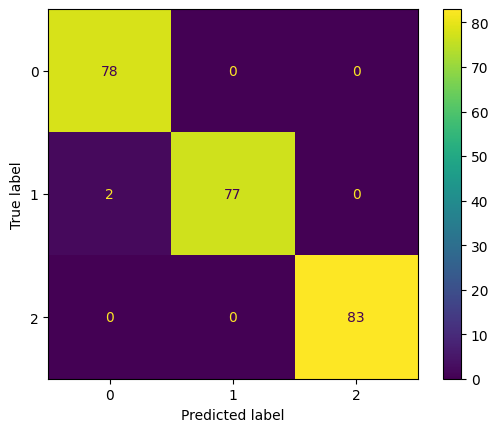

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels_flat = y_test.flatten()
pred_labels_flat = y_pred.flatten()

# Generate the classification report
report = classification_report(true_labels_flat, pred_labels_flat)

# Print the report
print(report)

cm = confusion_matrix(true_labels_flat, pred_labels_flat)

#Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(true_labels_flat)))
disp.plot()

<a name="baseline-accuracy"></a>
## Best ML model and baseline accuracy discussion
---

In [ ]:
### Approach 1. Train the model on each gesture independently. Use this model to predic a sequence of outputs by splitting the input into two separate videos.
### However, this approach and it's accuracy were not satifactory.

In [ ]:
### Approach 2. (Best ML Model) - The CNN-LSTM Seq2Seq Model, with time distribution and convolutional 1D.
### The time distributed layer helps apply the same mathematical convolutional operations on the input file.
### The shape of the input was (None, 2, 72, 6 ) and the same operations were performed on each 72 x 6 matrice for each video.
### This reduces the dimensionality.

"""
model_s2s = Sequential()
model_s2s.add(TimeDistributed(Conv1D(filters=72, kernel_size=3, activation='relu'), input_shape=(None,n_timesteps,n_features)))
model_s2s.add(TimeDistributed(Conv1D(filters=72, kernel_size=3, activation='relu')))
model_s2s.add(TimeDistributed(Dropout(0.5)))
model_s2s.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_s2s.add(TimeDistributed(Flatten()))
model_s2s.add(LSTM(128, activation='relu', return_sequences=True))
model_s2s.add(Dropout(0.3))
model_s2s.add(Dense(n_outputs, activation='softmax'))
model_s2s.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
"""

<a name="factor-summary"></a>
## Summary of what factor combination yields best prediction result
---

In [ ]:
"""
For the experimentation we tried the following hyper parameter combinations -
Conv1D - experimented with tanh and relu activation functions.
LSTM - numbers of neurons [32, 64, 128, 256], with 128 yielding the best results.
We started with 2 LSTM layers, taking cues from Milestone 2, however after experimentation
Single LSTM layer in combination with 2 Conv1D

"""

<a name="result-discssion"></a>
## Refine/repeat/discussion of the results
---

In [ ]:
"""
Experiments -

TimeDistributed with LSTM:
Apply LSTM to each time step independently using TimeDistributed.
Captures temporal dependencies within each time step.
Useful when modeling individual time step patterns.

TimeDistributed with Conv1D:
Apply convolution to each time step independently using TimeDistributed.
Aggregates results across time steps for further processing.
Useful for capturing local patterns and summarizing them.


LSTM in TimeDistributed:
Use TimeDistributed to wrap LSTM layer.
Allows LSTM to process each time step independently.
Useful for modeling temporal dependencies within each time step.


"""

In [ ]:
### Time Distributed with Conv1D yields the best results with test acuracy 100% when trained on the
### combined videos dataset generated.


# Bonus item B1 and B2
---

In [ ]:
"""
Colab Link: https://colab.research.google.com/drive/1Crg_-9QYl8q68fT5EQ3m_xY6C1apKqB1?usp=sharing
"""